# Regularized barycentric weak OT using generalized iterative scaling (GIS)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import squareform, pdist, cdist
from scipy.optimize import linprog
from ot import emd
from ot.weak import weak_optimal_transport

/home/johannes/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/johannes/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/johannes/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/johannes/miniconda3/lib/python3.7/site-packages/tensorflow/python/f

In [2]:
np.set_printoptions(suppress=True, precision=5)

## Generate data

In [3]:
M = 100
x = np.linspace(-1.0, 1.0, M)

In [4]:
# gaussians
scale = 0.2
translate = 0.3
mu = norm(loc=0.0, scale=scale).pdf(x)
mu /= mu.sum()
nu = 0.5*(norm(loc=-translate, scale=scale).pdf(x) + norm(loc=translate, scale=scale).pdf(x))
nu /= nu.sum()

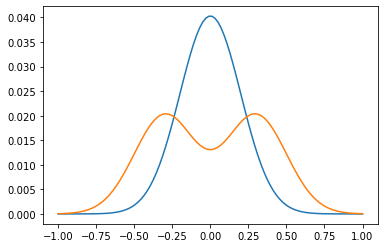

In [5]:
plt.plot(x, mu)
plt.plot(x, nu)

In [6]:
# choice of auxiliary grid
y = x

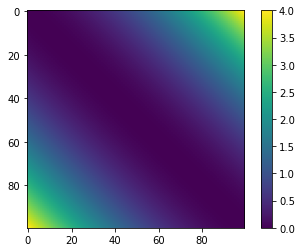

In [7]:
c = (x[:, None] - y[None])**2

plt.imshow(c)
plt.colorbar()
plt.show()

## Standard Monge-Kantorovich OT

In [8]:
pi = emd(mu, nu, c)

## Solve unregularized problem using weak OT solver from POT package

In [9]:
%%time
pi_pot = weak_optimal_transport(x[:, None], x[:, None], mu, nu)

CPU times: user 5.07 s, sys: 5 s, total: 10.1 s
Wall time: 1.6 s


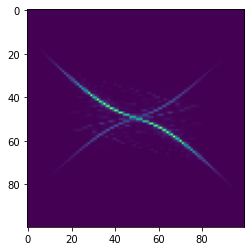

In [10]:
plt.imshow(pi_pot)

## Solve regularized problem using GIS

In [11]:
eps = 1e-10
K = np.exp(-c/eps)

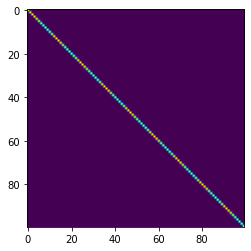

In [12]:
plt.imshow(K)

In [13]:
# weak OT loss
def weakOTcost(pi, mu, x, y):
    return (mu*(x - (pi/pi.sum(axis=1)[:, None]).dot(y))**2).sum()

In [14]:
%%time
n_iter_max = int(1e4)
err_thres = 1e-9
it = 0
err = np.inf
f_val = np.inf

xi_x = min(x)
xi_y = min(-y)
xiprime = max(max(x-xi_x), max(-y-xi_y))
Ax = (x - xi_x)/xiprime
Ax = np.stack([Ax, 1-Ax], axis=0)
Ay = (-y - xi_y)/xiprime
Ay = np.stack([Ay, 1-Ay], axis=0)
b = np.array([
    -(xi_x + xi_y)/xiprime,
    2+(xi_x + xi_y)/xiprime,
])

pix = np.ones_like(K)
piy = K.copy()

while it < n_iter_max and err > err_thres:

    f_val_old = f_val
    
    # nu constraint
    pix = pix * (nu / pix.sum(axis=0))[None, :]

    # mean constraint
    z = np.log(b[:, None] / (Ax.dot(pix.T) + Ay.dot(piy.T)))
    pix = pix * np.exp(Ax.T.dot(z)).T
    piy = piy * np.exp(Ay.T.dot(z)).T
    
    # mu constraint
    pix = pix * (mu / pix.sum(axis=1))[:, None]
    piy = piy * (mu / piy.sum(axis=1))[:, None]
    
    # convergence management
    it += 1
    f_val = weakOTcost(pix, mu, x, y)
    abs_delta = abs(f_val - f_val_old)
    err_rel = abs_delta / abs(f_val)
    err = min(abs_delta, err_rel)

print(f"Terminated after {it} iterations with error {err}.")

Terminated after 366 iterations with error 9.845283508850067e-10.
CPU times: user 3.75 s, sys: 3.87 s, total: 7.62 s
Wall time: 1.21 s


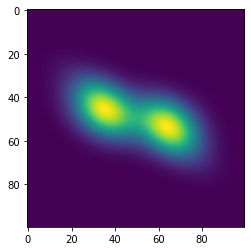

In [15]:
plt.imshow(pix)

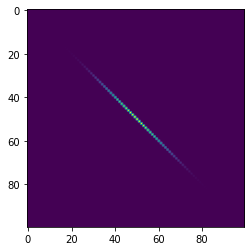

In [16]:
plt.imshow(piy)

## Comparison of weak OT cost

In [17]:
weakOTcost(pix, mu, x, y)

5.1500195181965544e-08

In [18]:
weakOTcost(pi_pot, mu, x, y)

3.7828997326398495e-07

## Comparison of transport plans

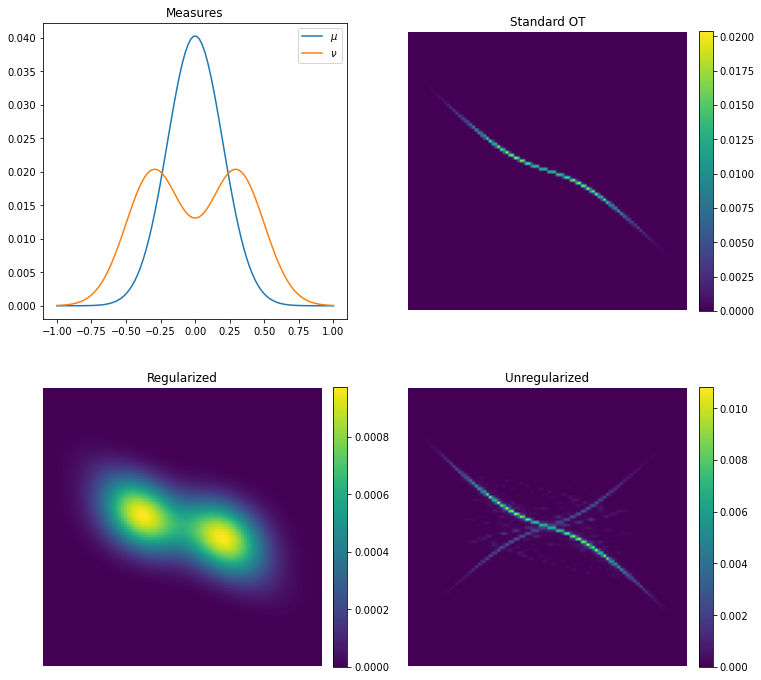

In [19]:
# make this one figure
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# measures
ax[0, 0].plot(x, mu, label=r'$\mu$')
ax[0, 0].plot(x, nu, label=r'$\nu$')
ax[0, 0].legend()
ax[0, 0].title.set_text('Measures')

# standard OT
h = ax[0, 1].imshow(pi)
fig.colorbar(h, fraction=0.046, pad=0.04, ax=ax[0, 1])
ax[0, 1].set_axis_off()
ax[0, 1].title.set_text('Standard OT')

# plans
plans = [pix, pi_pot]
subtitles = ['Regularized', 'Unregularized']
for i, (plan, title) in enumerate(zip(plans, subtitles)):
    h = ax[1, i].imshow(plan)
    fig.colorbar(h, fraction=0.046, pad=0.04, ax=ax[1, i])
    ax[1, i].set_axis_off()
    ax[1, i].title.set_text(title)
if False:
# if True:
    plt.savefig(os.path.join('0utputs', 'constraints', 'weakOT.pdf'), pad_inches=0.01, bbox_inches='tight')